Train: 76483, Val: 21852, Test: 10927
✅ 已保存 Accuracy_Bootstrap 到文件 xLSTM bootstrap_accuracy.csv

=== Final Test Set Performance ===
Test Acc: 99.06% | F1: 0.9905 | Sensitivity: 0.9906 | PPV: 0.9905 | Specificity: 0.9758
🕒 Inference Time on Test Set: 0.72 seconds

=== Confidence Intervals (95%) ===
Accuracy: 99.0591 [98.8652, 99.2313]
F1 Score: 0.9904 [0.9885, 0.9921]
Sensitivity: 0.9906 [0.9887, 0.9922]
Precision: 0.9905 [0.9886, 0.9923]
Specificity: 0.9756 [0.9694, 0.9815]


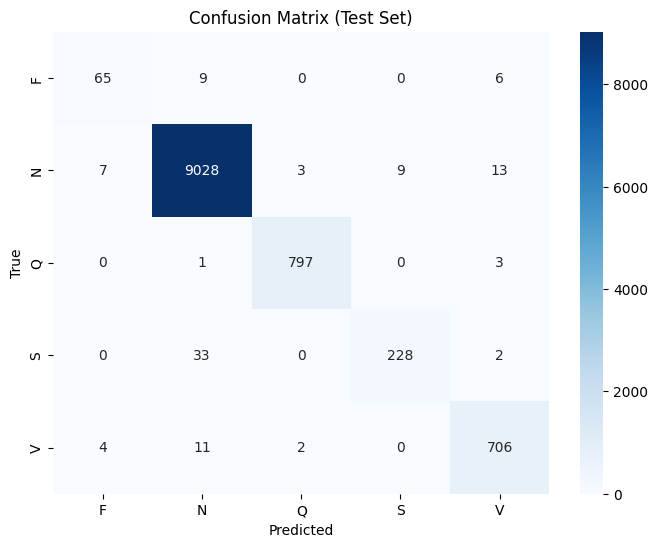


=== Model Complexity ===

=== Model Complexity (via fvcore) ===
📊 Params: 5257.59 K
📊 FLOPs: 5.52 M


ImprovedxLSTM(
  (xlstm): xLSTM(
    (layers): ModuleList(
      (0): sLSTMBlock(
        (layer_norm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (causal_conv): CausalConv1D(
          (conv): Conv1d(1, 1, kernel_size=(4,), stride=(1,), padding=(3,))
        )
        (Wz): BlockDiagonal(
          (blocks): ModuleList(
            (0-7): 8 x Linear(in_features=300, out_features=64, bias=True)
          )
        )
        (Wi): BlockDiagonal(
          (blocks): ModuleList(
            (0-7): 8 x Linear(in_features=300, out_features=64, bias=True)
          )
        )
        (Wf): BlockDiagonal(
          (blocks): ModuleList(
            (0-7): 8 x Linear(in_features=300, out_features=64, bias=True)
          )
        )
        (Wo): BlockDiagonal(
          (blocks): ModuleList(
            (0-7): 8 x Linear(in_features=300, out_features=64, bias=True)
          )
        )
        (Rz): BlockDiagonal(
          (blocks): ModuleList(
            (0-7): 8 x Lin

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 15 10:40:23 2025

@author: 29551
"""
!pip install fvcore
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import time
from fvcore.nn import FlopCountAnalysis, parameter_count
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

# 1. 数据加载与预处理
data = pd.read_csv('/kaggle/input/mitbih/ECG_data.csv')

# 提取信号和标签
signals = data['Signal'].apply(lambda x: np.fromstring(x[1:-1], sep=',')).values
labels = data['Label'].values

# 转换信号为NumPy数组
signals = np.array([np.array(signal) for signal in signals])

# 标签编码
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
# 数据分割
X_train, X_temp, y_train, y_temp = train_test_split(
    signals, labels_encoded, test_size=0.3, random_state=42, stratify=labels_encoded)

# 第二步：将临时集中的 2/3 设为验证集（20%），1/3 设为测试集（10%）
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)

# 检查划分比例
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# 2. 转换输入格式
X_train = X_train.reshape(-1, 1, 300)
# 每个样本300个时间步，每个时间步一个特征 (channels=1, seq_len=300)
X_val = X_val.reshape(-1, 1, 300)
X_test = X_test.reshape(-1, 1, 300)


# 转换为Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)



class CausalConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        super(CausalConv1D, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation, **kwargs)
 
    def forward(self, x):
        x = self.conv(x)
        return x[:, :, :-self.padding]
 
 
class BlockDiagonal(nn.Module):
    def __init__(self, in_features, out_features, num_blocks):
        super(BlockDiagonal, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_blocks = num_blocks
 
        assert out_features % num_blocks == 0
 
        block_out_features = out_features // num_blocks
 
        self.blocks = nn.ModuleList([
            nn.Linear(in_features, block_out_features)
            for _ in range(num_blocks)
        ])
 
    def forward(self, x):
        x = [block(x) for block in self.blocks]
        x = torch.cat(x, dim=-1)
        return x


class  mLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=2):
        super(mLSTMBlock, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.proj_factor = proj_factor
 
        assert proj_factor > 0
 
        self.layer_norm = nn.LayerNorm(input_size)
        self.up_proj_left = nn.Linear(input_size, int(input_size * proj_factor))
        self.up_proj_right = nn.Linear(input_size, self.hidden_size)
        self.down_proj = nn.Linear(self.hidden_size, input_size)
 
        self.causal_conv = CausalConv1D(1, 1, 4)
        self.skip_connection = nn.Linear(int(input_size * proj_factor), self.hidden_size)
 
        self.Wq = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wk = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wv = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wi = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wf = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wo = nn.Linear(int(input_size * proj_factor), self.hidden_size)
 
        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)
 
    def forward(self, x, prev_state):
        h_prev, c_prev, n_prev, m_prev = prev_state
 
        h_prev = h_prev.to(x.device)
        c_prev = c_prev.to(x.device)
        n_prev = n_prev.to(x.device)
        m_prev = m_prev.to(x.device)
 
        assert x.size(-1) == self.input_size
        x_norm = self.layer_norm(x)
        x_up_left = self.up_proj_left(x_norm)
        x_up_right = self.up_proj_right(x_norm)
 
        x_conv = F.silu(self.causal_conv(x_up_left.unsqueeze(1)).squeeze(1))
        x_skip = self.skip_connection(x_conv)
 
        q = self.Wq(x_conv)
        k = self.Wk(x_conv) / (self.head_size ** 0.5)
        v = self.Wv(x_up_left)
 
        i_tilde = self.Wi(x_conv)
        f_tilde = self.Wf(x_conv)
        o = torch.sigmoid(self.Wo(x_up_left))
 
        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t)
        f = torch.exp(f_tilde + m_prev - m_t)
 
        c_t = f * c_prev + i * (v * k)  # v @ k.T
        n_t = f * n_prev + i * k
        h_t = o * (c_t * q) / torch.max(torch.abs(n_t.T @ q), 1)[0]  # o * (c @ q) / max{|n.T @ q|, 1}
 
        output = h_t
        output_norm = self.group_norm(output)
        output = output_norm + x_skip
        output = output * F.silu(x_up_right)
        output = self.down_proj(output)
        final_output = output + x
 
        return final_output, (h_t, c_t, n_t, m_t)
 
class sLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=4 / 3):
        super(sLSTMBlock, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.proj_factor = proj_factor
 
        assert proj_factor > 0
 
        self.layer_norm = nn.LayerNorm(input_size)
        self.causal_conv = CausalConv1D(1, 1, 4)
 
        self.Wz = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wi = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wf = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wo = BlockDiagonal(input_size, self.hidden_size, num_heads)
 
        self.Rz = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ri = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Rf = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ro = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
 
        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)
 
        self.up_proj_left = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.up_proj_right = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.down_proj = nn.Linear(int(self.hidden_size * proj_factor), input_size)
 
    def forward(self, x, prev_state):
        assert x.size(-1) == self.input_size
        h_prev, c_prev, n_prev, m_prev = prev_state
 
        h_prev = h_prev.to(x.device)
        c_prev = c_prev.to(x.device)
        n_prev = n_prev.to(x.device)
        m_prev = m_prev.to(x.device)
 
        x_norm = self.layer_norm(x)
        x_conv = F.silu(self.causal_conv(x_norm.unsqueeze(1)).squeeze(1))
 
        z = torch.tanh(self.Wz(x_norm) + self.Rz(h_prev))
        o = torch.sigmoid(self.Wo(x_norm) + self.Ro(h_prev))
        i_tilde = self.Wi(x_conv) + self.Ri(h_prev)
        f_tilde = self.Wf(x_conv) + self.Rf(h_prev)
 
        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t)
        f = torch.exp(f_tilde + m_prev - m_t)
 
        c_t = f * c_prev + i * z
        n_t = f * n_prev + i
        h_t = o * c_t / n_t
 
        output = h_t
        output_norm = self.group_norm(output)
        output_left = self.up_proj_left(output_norm)
        output_right = self.up_proj_right(output_norm)
        output_gated = F.gelu(output_right)
        output = output_left * output_gated
        output = self.down_proj(output)
        final_output = output + x
 
        return final_output, (h_t, c_t, n_t, m_t)
 
class xLSTM(nn.Module):
    def __init__(self, input_size, head_size, num_heads, layers, batch_first=False, proj_factor_slstm=4 / 3,
                 proj_factor_mlstm=2):
        super(xLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.layers = layers
        self.num_layers = len(layers)
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor_slstm
        self.proj_factor_mlstm = proj_factor_mlstm
 
        self.layers = nn.ModuleList()
        for layer_type in layers:
            if layer_type == 's':
                layer = sLSTMBlock(input_size, head_size, num_heads, proj_factor_slstm)
            elif layer_type == 'm':
                layer = mLSTMBlock(input_size, head_size, num_heads, proj_factor_mlstm)
            else:
                raise ValueError(f"Invalid layer type: {layer_type}. Choose 's' for sLSTM or 'm' for mLSTM.")
            self.layers.append(layer)
 
    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()
 
        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)
 
        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)
 
        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state

    
# 改进的xLSTM模型
class ImprovedxLSTM(nn.Module):
    def __init__(self, input_size, head_size, num_heads, num_layers, output_dim):
        super(ImprovedxLSTM, self).__init__()
        self.xlstm = xLSTM(input_size, head_size, num_heads, layers=['s'] * num_layers[0]+['m'] * num_layers[1], batch_first=True)
        self.classifier = nn.Sequential(
            nn.LayerNorm(input_size),
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, output_dim)
        )

    def forward(self, x, state=None):
        xlstm_out, state = self.xlstm(x, state)
        output = xlstm_out[:, -1, :]  # 取最后一个时间步的输出
        output = self.classifier(output)  # 输出为 logits
        return output, state

    
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        # 输入为logits，需要通过softmax转换为概率分布
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # 计算预测概率
        p_t = torch.exp(-BCE_loss)
        
        # 计算Focal Loss的加权项
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * BCE_loss
        
        # 根据reduction方式计算损失
        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss



def save_bootstrap(y_true, y_pred, metric_fn, num_iterations=1000, alpha=0.05, csv_path="xLSTM bootstrap_accuracy.csv"):

    n = len(y_true)
    stats = []

    for _ in range(num_iterations):
        indices = np.random.choice(np.arange(n), size=n, replace=True)
        stat = metric_fn(np.array(y_true)[indices], np.array(y_pred)[indices])
        stats.append(stat)

    # === 如果是 Accuracy 就保存 ===
    if metric_fn.__name__ == "accuracy_score":
        try:
            df = pd.read_csv(csv_path)
        except FileNotFoundError:
            df = pd.DataFrame()

        df["xLSTM Accuracy_Bootstrap"] = stats  # 直接覆盖或新增该列

        df.to_csv(csv_path, index=False)
        print(f"✅ 已保存 Accuracy_Bootstrap 到文件 {csv_path}")

    # === 返回均值 ± 置信区间 ===
    lower = np.percentile(stats, 100 * alpha / 2)
    upper = np.percentile(stats, 100 * (1 - alpha / 2))
    return np.mean(stats), lower, upper

def specificity_score_weighted(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm.sum() - cm.sum(axis=0) - cm.sum(axis=1) + np.diagonal(cm)
    fp = cm.sum(axis=0) - np.diagonal(cm)
    spec_per_class = tn / (tn + fp + 1e-6)
    class_support = cm.sum(axis=1)
    total = class_support.sum()
    return np.sum((class_support / total) * spec_per_class)

# 模型实例化
input_size = 300  # 每个输入的长度
head_size = 64  # 每个头的大小
num_heads = 8  # 头的数量
num_layers = [1, 1]  # 层数
output_dim = 5  # 输出类别数量（你有5个类别）

model = ImprovedxLSTM(input_size, head_size, num_heads, num_layers, output_dim)

# 选择设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 定义优化器和学习率调度器
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam优化器

# 定义损失函数
criterion = FocalLoss()  # 使用 Focal Loss

def compute_test_metrics(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []
    
    start_time = time.time()
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            output=output[0]
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
    end_time = time.time()
    elapsed_time = end_time - start_time

    accuracy = 100 * correct / total
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    sensitivity = recall_score(all_targets, all_predictions, average='weighted')
    precision = precision_score(all_targets, all_predictions, average='weighted')

    conf_matrix = confusion_matrix(all_targets, all_predictions)
    tn = conf_matrix.sum() - conf_matrix.sum(axis=0) - conf_matrix.sum(axis=1) + np.diagonal(conf_matrix)
    fp = conf_matrix.sum(axis=0) - np.diagonal(conf_matrix)
    specificity_per_class = tn / (tn + fp + 1e-6)
    samples_per_class = conf_matrix.sum(axis=1)
    total_samples = np.sum(samples_per_class)
    specificity = np.sum((samples_per_class / total_samples) * specificity_per_class)


    # === CI 计算 ===
    acc_m, acc_l, acc_u = save_bootstrap(
        y_true=all_targets,
        y_pred=all_predictions,
        metric_fn=accuracy_score
    )

    f1_m, f1_l, f1_u = save_bootstrap(
        y_true=all_targets,
        y_pred=all_predictions,
        metric_fn=lambda y_t, y_p: f1_score(y_t, y_p, average='weighted')
    )

    rec_m, rec_l, rec_u = save_bootstrap(
        y_true=all_targets,
        y_pred=all_predictions,
        metric_fn=lambda y_t, y_p: recall_score(y_t, y_p, average='weighted')
    )

    ppv_m, ppv_l, ppv_u = save_bootstrap(
        y_true=all_targets,
        y_pred=all_predictions,
        metric_fn=lambda y_t, y_p: precision_score(y_t, y_p, average='weighted')
    )

    spe_m, spe_l, spe_u = save_bootstrap(
        y_true=all_targets,
        y_pred=all_predictions,
        metric_fn=specificity_score_weighted  # ✅ 你自定义的函数
    )


    ci_dict = {
        'Accuracy': (acc_m*100, acc_l*100, acc_u*100),
        'F1 Score': (f1_m, f1_l, f1_u),
        'Sensitivity': (rec_m, rec_l, rec_u),
        'Precision': (ppv_m, ppv_l, ppv_u),
        'Specificity': (spe_m, spe_l, spe_u)
    }

    return accuracy, f1, sensitivity, precision, specificity, conf_matrix, elapsed_time, ci_dict
    
def plot_acc_loss(history):
    epochs = range(1, len(history['train_acc']) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)', color='tab:blue')
    ax1.plot(epochs, history['train_acc'], label='Train Accuracy', color='tab:blue', linestyle='-')
    ax1.plot(epochs, history['val_acc'], label='Val Accuracy', color='tab:blue', linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(90,100)
    ax1.grid(True)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Loss', color='tab:red')
    ax2.plot(epochs, history['train_loss'], label='Train Loss', color='tab:red', linestyle='-')
    ax2.plot(epochs, history['val_loss'], label='Val Loss', color='tab:red', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0,0.03)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

    plt.title('Accuracy and Loss over Epochs')
    fig.tight_layout()
    plt.savefig("xLSTM Accuracy_Loss Dual Axis.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()


def evaluate(model,test_loader):
    best_model_path = '/kaggle/input/xlstm-best/xLSTM best_model.pth'    
    # === 重新加载最优模型进行测试 ===
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    # === 测试集评估 ===
    test_acc, test_f1, test_sen, test_ppv, test_spe, conf_matrix, test_time, ci_dict = compute_test_metrics(model, test_loader)


    print("\n=== Final Test Set Performance ===")
    print(f"Test Acc: {test_acc:.2f}% | F1: {test_f1:.4f} | Sensitivity: {test_sen:.4f} | "
          f"PPV: {test_ppv:.4f} | Specificity: {test_spe:.4f}")
    print(f"🕒 Inference Time on Test Set: {test_time:.2f} seconds")

    print("\n=== Confidence Intervals (95%) ===")
    for metric, (mean, lower, upper) in ci_dict.items():
        print(f"{metric}: {mean:.4f} [{lower:.4f}, {upper:.4f}]")

    # === 保存结果 ===
    pd.DataFrame({
        'Accuracy (%)': [test_acc],
        'F1 Score': [test_f1],
        'Sensitivity': [test_sen],
        'Precision (PPV)': [test_ppv],
        'Specificity': [test_spe]
    }).to_csv("xLSTM Test Metrics.csv", index=False)
    ci_df = pd.DataFrame({
        "Metric": list(ci_dict.keys()),
        "Mean": [v[0] for v in ci_dict.values()],
        "Lower CI (95%)": [v[1] for v in ci_dict.values()],
        "Upper CI (95%)": [v[2] for v in ci_dict.values()],
    })
    ci_df.to_csv("xLSTM_Test_Metrics_Confidence_Interval.csv", index=False)
    # 混淆矩阵图
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Test Set)")
    plt.savefig("xLSTM Confusion Matrix.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    # === 计算模型参数量和 FLOPs ===
    print("\n=== Model Complexity ===")
    # === 构造一个模拟输入，保持与模型输入一致 ===
    input_tensor = torch.randn(1, 1, X_train_tensor.shape[2]).to(next(model.parameters()).device)

    # === 使用 fvcore 分析 FLOPs 和参数量 ===
    flops = FlopCountAnalysis(model, input_tensor)
    params = parameter_count(model)

    # === 单位换算 ===
    flops_m = flops.total() / 1e6
    params_k = params[""] / 1e3

    # === 打印模型复杂度 ===
    print("\n=== Model Complexity (via fvcore) ===")
    print(f"📊 Params: {params_k:.2f} K")
    print(f"📊 FLOPs: {flops_m:.2f} M")

    # === 保存到文件 ===
    with open("xLSTM_Model_Complexity.txt", "w") as f:
        f.write(f"Params: {params_k:.2f} K\n")
        f.write(f"FLOPs: {flops_m:.2f} M\n")
        f.write(f"Test Time: {test_time:.2f} sec\n")
    return model

evaluate(model, test_loader)
        
  




        